In [1]:
!pip install pulp
!pip install pandas
!pip install matplotlib
!pip install IPython

You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [8]:
from pulp import *
import numpy as np
import pandas as pd
import re 
import matplotlib.pyplot as plt
from IPython.display import Image

In [3]:
%matplotlib inline

In [4]:
pd.set_option('display.max_colwidth',400)

In [9]:
data = pd.read_csv('../Data/Misc/kerala_vacay1.csv',delimiter="\t") #Data from Makemytrip

In [10]:
data

,destination,duration,cost,description
0,Mini Kerala_F,4,24284,2N Munnar - 1N Thekkady - 1N Allepey
1,Splendours of Kerala,5,28042,1N Cochin - 2N Munnar - 1N Thekkady - 1N Allepey
2,Kerala - A Lovers Paradise,6,33404,2N Munnar - 1N Thekkady - 1N Allepey - 2N Kovalam and Poovar
3,Mini Kerala_WF,4,11574,2N Munnar - 1N Thekkady - 1N Allepey
4,Kerala Paradise,6,31148,2N Munnar - 1N Thekkady - 2N Kovalam and Poovar - 1N Allepey
5,A Relaxing holiday to Kerala,7,36221,1N Cochin - 2N Munnar - 1N Thekkady - 1N Allepey - 2N Kovalam and Poovar
6,Kerala Memories,5,33800,2N Munnar - 1N Allepey - 2N Kovalam and Poovar
7,Made in Heaven - Vibrant Kerala,5,26714,3N Munnar - 1N Thekkady - 1N Allepey
8,A Short Trip to Allepey and Munnar,3,22267,1N Allepey - 2N Munnar
9,Mini Kerala with Shared Vehicle,4,10999,2N Munnar - 1N Thekkady - 1N Allepey


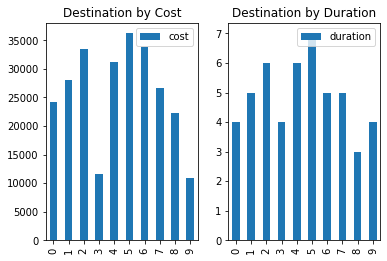

In [11]:
fig, axs = plt.subplots(1,2)
my_plot = data[['destination', 'cost']].plot(kind='bar', title="Destination by Cost", ax=axs[0])
my_plot = data[['destination', 'duration']].plot(kind='bar', title="Destination by Duration", ax=axs[1])

In [12]:
# create the LP object, set up as a minimization problem --> since we want to minimize the costs 

prob = pulp.LpProblem('KeralaTrip', pulp.LpMinimize)

### Create Decision Variables:

In [13]:
decision_variables = []
for rownum, row in data.iterrows():
	variable = str('x' + str(rownum))
	variable = pulp.LpVariable(str(variable), lowBound = 0, upBound = 1, cat= 'Integer') #make variables binary
	decision_variables.append(variable)

print ("Total number of decision_variables: " + str(len(decision_variables)))
print ("Array with Decision Variables:" + str(decision_variables))

Total number of decision_variables: 10
Array with Decision Variables:[x0, x1, x2, x3, x4, x5, x6, x7, x8, x9]


Define Objective Function: (Minimixing the Cost of The Trip)

The variable prob now begins collecting problem data with the += operator. The objective function is logically entered first, with an important comma , at the end of the statement and a short string explaining what this objective function is:

In [14]:
total_cost = ""
for rownum, row in data.iterrows():
	for i, schedule in enumerate(decision_variables):
		if rownum == i:
			formula = row['cost']*schedule
			total_cost += formula

prob += total_cost
print ("Optimization function: " + str(total_cost))

Optimization function: 24284*x0 + 28042*x1 + 33404*x2 + 11574*x3 + 31148*x4 + 36221*x5 + 33800*x6 + 26714*x7 + 22267*x8 + 10999*x9


Define Constrains: (Selected Packages should not exceed total vacation days available)



In [15]:
aval_vacation_days = 5
total_vacation_days = ""
for rownum, row in data.iterrows():
	for i, schedule in enumerate(decision_variables):
		if rownum == i:
			formula = row['duration']*schedule
			total_vacation_days += formula

prob += (total_vacation_days == aval_vacation_days)

In [16]:
print(prob)
prob.writeLP("GoingOnVacation.lp" )

KeralaTrip:
MINIMIZE
24284*x0 + 28042*x1 + 33404*x2 + 11574*x3 + 31148*x4 + 36221*x5 + 33800*x6 + 26714*x7 + 22267*x8 + 10999*x9 + 0
SUBJECT TO
_C1: 4 x0 + 5 x1 + 6 x2 + 4 x3 + 6 x4 + 7 x5 + 5 x6 + 5 x7 + 3 x8 + 4 x9 = 5

VARIABLES
0 <= x0 <= 1 Integer
0 <= x1 <= 1 Integer
0 <= x2 <= 1 Integer
0 <= x3 <= 1 Integer
0 <= x4 <= 1 Integer
0 <= x5 <= 1 Integer
0 <= x6 <= 1 Integer
0 <= x7 <= 1 Integer
0 <= x8 <= 1 Integer
0 <= x9 <= 1 Integer



[x0, x1, x2, x3, x4, x5, x6, x7, x8, x9]

The Actual Optimization:

In [17]:
optimization_result = prob.solve()

assert optimization_result == pulp.LpStatusOptimal
print("Status:", LpStatus[prob.status])
print("Optimal Solution to the problem: ", value(prob.objective))
print ("Individual decision_variables: ")
for v in prob.variables():
	print(v.name, "=", v.varValue)

Status: Optimal
Optimal Solution to the problem:  26714.0
Individual decision_variables: 
x0 = 0.0
x1 = 0.0
x2 = 0.0
x3 = 0.0
x4 = 0.0
x5 = 0.0
x6 = 0.0
x7 = 1.0
x8 = 0.0
x9 = 0.0


In [18]:
variable_name = []
variable_value = []

for v in prob.variables():
	variable_name.append(v.name)
	variable_value.append(v.varValue)

df = pd.DataFrame({'variable': variable_name, 'value': variable_value})
for rownum, row in df.iterrows():
	value_ = re.findall(r'(\d+)', row['variable'])
	df.loc[rownum, 'variable'] = int(value_[0])

df = df.sort_index(by='variable')

#append results
for rownum, row in data.iterrows():
	for results_rownum, results_row in df.iterrows():
		if rownum == results_row['variable']:
			data.loc[rownum, 'decision'] = results_row['value']
            
data[:5]

/Users/abhiram/Desktop/Coding/virtual_environments/py37/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: by argument to sort_index is deprecated, please use .sort_values(by=...)
  del sys.path[0]


,destination,duration,cost,description,decision
0,Mini Kerala_F,4,24284,2N Munnar - 1N Thekkady - 1N Allepey,0.0
1,Splendours of Kerala,5,28042,1N Cochin - 2N Munnar - 1N Thekkady - 1N Allepey,0.0
2,Kerala - A Lovers Paradise,6,33404,2N Munnar - 1N Thekkady - 1N Allepey - 2N Kovalam and Poovar,0.0
3,Mini Kerala_WF,4,11574,2N Munnar - 1N Thekkady - 1N Allepey,0.0
4,Kerala Paradise,6,31148,2N Munnar - 1N Thekkady - 2N Kovalam and Poovar - 1N Allepey,0.0


The Final Decisions and Results of the Optimization in the "User Friendly Way":

In [19]:
data[data['decision'] == 1]

,destination,duration,cost,description,decision
7,Made in Heaven - Vibrant Kerala,5,26714,3N Munnar - 1N Thekkady - 1N Allepey,1.0


In [22]:
def return_optimal_solution(vacay_days):
    try:
        prob = pulp.LpProblem('KeralaTrip', pulp.LpMinimize)

        decision_variables = []
        for rownum, row in data.iterrows():
            variable = str('x' + str(rownum))
            variable = pulp.LpVariable(str(variable), lowBound = 0, upBound = 1, cat= 'Integer') #make variables binary
            decision_variables.append(variable)

        print ("Total number of decision_variables: " + str(len(decision_variables)))
        print ("Array with Decision Variables:" + str(decision_variables)+"\n")

        total_cost = ""
        for rownum, row in data.iterrows():
            for i, schedule in enumerate(decision_variables):
                if rownum == i:
                    formula = row['cost']*schedule
                    total_cost += formula

        prob += total_cost
        print ("Optimization function: " + str(total_cost))
        aval_vacation_days = vacay_days
        total_vacation_days = ""
        for rownum, row in data.iterrows():
            for i, schedule in enumerate(decision_variables):
                if rownum == i:
                    formula = row['duration']*schedule
                    total_vacation_days += formula

        prob += (total_vacation_days == aval_vacation_days)
        print(prob)
        prob.writeLP("GoingOnVacation.lp" )
        optimization_result = prob.solve()

        assert optimization_result == pulp.LpStatusOptimal
        print("Status:", LpStatus[prob.status])
        print("Optimal Solution to the problem: ", value(prob.objective))
        print ("Individual decision_variables: ")
        for v in prob.variables():
            print(v.name, "=", v.varValue)

        variable_name = []
        variable_value = []

        for v in prob.variables():
            variable_name.append(v.name)
            variable_value.append(v.varValue)

        df = pd.DataFrame({'variable': variable_name, 'value': variable_value})
        for rownum, row in df.iterrows():
            value_ = re.findall(r'(\d+)', row['variable'])
            df.loc[rownum, 'variable'] = int(value_[0])

        df = df.sort_index(by='variable')

        #append results
        for rownum, row in data.iterrows():
            for results_rownum, results_row in df.iterrows():
                if rownum == results_row['variable']:
                    data.loc[rownum, 'decision'] = results_row['value']

        print(data)
        print(data[data['decision'] == 1])
    except Exception as e:
        print("Ask for more leaves, dummy")

In [23]:
return_optimal_solution(2)

Total number of decision_variables: 10
Array with Decision Variables:[x0, x1, x2, x3, x4, x5, x6, x7, x8, x9]

Optimization function: 24284*x0 + 28042*x1 + 33404*x2 + 11574*x3 + 31148*x4 + 36221*x5 + 33800*x6 + 26714*x7 + 22267*x8 + 10999*x9
KeralaTrip:
MINIMIZE
24284*x0 + 28042*x1 + 33404*x2 + 11574*x3 + 31148*x4 + 36221*x5 + 33800*x6 + 26714*x7 + 22267*x8 + 10999*x9 + 0
SUBJECT TO
_C1: 4 x0 + 5 x1 + 6 x2 + 4 x3 + 6 x4 + 7 x5 + 5 x6 + 5 x7 + 3 x8 + 4 x9 = 2

VARIABLES
0 <= x0 <= 1 Integer
0 <= x1 <= 1 Integer
0 <= x2 <= 1 Integer
0 <= x3 <= 1 Integer
0 <= x4 <= 1 Integer
0 <= x5 <= 1 Integer
0 <= x6 <= 1 Integer
0 <= x7 <= 1 Integer
0 <= x8 <= 1 Integer
0 <= x9 <= 1 Integer

Ask for more leaves, dummy
